# **End-to-End Diabetes Machine Learning Pipeline I**

1. Exploratory Data Analysis
2. Data Preprocessing & Feature Engineering
3. Base Models
4. Automated Hyperparameter Optimization
5. Stacking & Ensemble Learning
6. Prediction for a New Observation
7. Pipeline Main Function

* Pipeline bir boru hattı demektir, uç uca eklenerek belirli bir aktarma işlemini temsil eder.

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

### **1. Exploratory Data Analysis**


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

▶ **check_df :** Veri seti hakkında genel özel bilgi çıkarır.

In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

▶ **cat_summary :** Kategorik değişkenin sınıf frekansı ve sınıflarının oranını ifade eder. 

▶ **plot=False** değil de **True** yapılırsa ilgili kategorik değişken için sütun grafiği oluşturur.

In [8]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

▶ **num_summary :** Sayısal değişkenleri inceleme fonksiyonu aslında describe işlemi gerçekleştirir. Yine plot = True yapılırsa ilgili nümerik değişken için grafik oluşturur.

In [9]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


▶ **target_summary_with_num :** Bağımlı değişken sayısal bir değişkenle özetlenmek istenirse kullanılabilir.

In [10]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


▶ **target_summary_with_cat :** Bağımlı değişkeni kategorik bir değişkenle özetlenmek istenirse kullanılabilir.

In [11]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

▶ **correlation_matrix :** Sayısal değişkenler arası korelasyonu hesaplayacak.

In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [13]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [14]:
df = pd.read_csv("/content/gdrive/MyDrive/DSMLBC10/week_11 (08.12.22-14.12.22) ml/dataset/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

* **Bazı bilgiler iş bilgisine göre sorun yaratabilir mesela bu veri setinde kan basıncı 0 olamaz ama 0 yazılmıştır. Muhtemelen NA olan değerler 0 ile değiştirilmiş. Bu kurs kapsamında incelenmemiştir.**

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################
                          count        mean         std     min       25%       50%        75%     max
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000    3.0000    6.00000   17.00
Glucose                   768.0  120.894531   31.972618   0.000  99.00000  117.0000  140.25000  199.00
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   72.0000   80.00000  122.00
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   23.0000   32.00000   99.00
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   30.5000  127.25000  846.00
BMI                       768.0   31.992578    7.884160   0.000  27.30000   32.0000   36.60000   67.10
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375    0.3725    0.62625    2.42
Age                       768.0   33.240885   11.760232  21.000  24

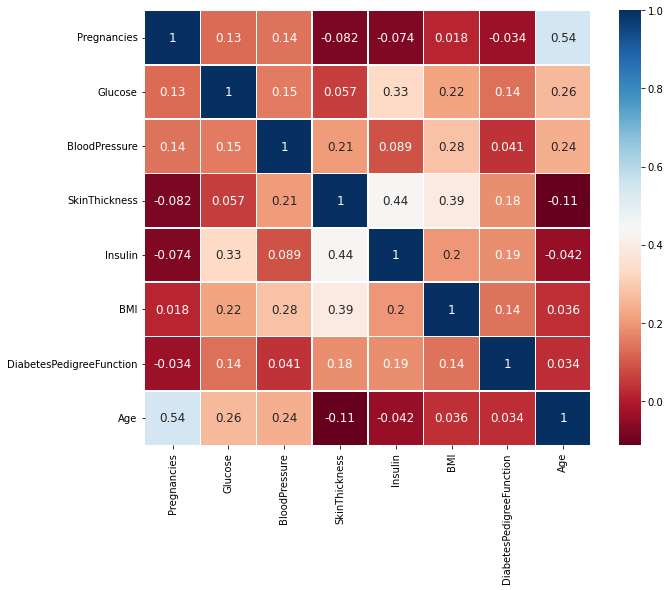

In [16]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

# Sayısal değişkenlerin incelenmesi
print(df[num_cols].describe().T)

# for col in num_cols:
#     num_summary(df, col, plot=True)

# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

In [17]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




### **2. Data Preprocessing & Feature Engineering**

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

▶ **outlier_thresholds :** Fonksiyon, kendisine verilen değişkeni alt ve üst eşik değerlerini hesaplamaktadır.

In [19]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


▶ **replace_with_thresholds :** Aykırı değer yerine kullanılması istenilen eşik değeri ifade eder.

In [20]:
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

▶ **check_outlier :** Herhangi bir değişkende aykırı değer var mı? yok mu? sorusuna cevap verir.

In [21]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
# drop_first=False true yaparsan label encoder yapar.

In [22]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [23]:
# Değişken isimlerini büyütmek
df.columns = [col.upper() for col in df.columns]

In [24]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

* Burada dikkat edilmesi gereken nokta, Glucose verisi için ağaç yöntemi uygulandığında en optimum hangi değerden ayrılır sorusunu bulmak için oldukça zengin bir içeriğe sahip fakat biz yukarıda 2 sınıflı kategorik bir değişken haline getirdik ve bu oluşturulan yeni değişken tam olarak Glucose verisinin tüm bilgilerini içermiyor olabilir. 

* Yeni bir değişken oluşturdum eskisini silmeli miyim? sorusuna yanıtta **şimdilik dursundur**. Belki yeni değişken bizim için önemli olmayacak silme konusuna model oluşturulduktan sonradan karar vermelisin.

In [25]:
# Age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

In [26]:
# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])

#bins -1 den başlatmak -1 dahil değil 0 dahil sonrası demek sıfırı sürecin içine katmak için bu şekilde yazılmıştır.

In [27]:
# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

In [28]:
check_df(df)

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME NEW_GLUCOSE_CAT NEW_AGE_CAT NEW_BMI_RANGE NEW_BLOODPRESSURE
0            6      148             72             35        0  33.6                     0.627   50        1     prediabetes   middleage         obese            normal
1       

In [29]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [30]:
for col in cat_cols:
    cat_summary(df, col)

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
##########################################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################
             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
##########################################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healty                 102  13.281250
underweight             15   1.953125
##########################################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
##########################################


In [31]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [32]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [33]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [34]:
check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_old                  uint8
NEW_AGE_CAT_young                uint8
NEW_GLUCOSE_CAT_prediabetes      uint8
NEW_BMI_RANGE_healty             uint8
NEW_BMI_RANGE_overweight         uint8
NEW_BMI_RANGE_obese              uint8
NEW_BLOODPRESSURE_hs1            uint8
NEW_BLOODPRESSURE_hs2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_old  NEW_AGE_CAT_young  NEW_GLUCOSE_CAT_pr

In [35]:
df.columns = [col.upper() for col in df.columns]

In [36]:
# Son güncel değişken türlerimi tutuyorum. eklediğin değişkenleri de grab_col_names fonk uygula
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [37]:
cat_cols

['NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [38]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

# çok değişkenli bir etki aykırı olmayan bir değeri aykırı hale getirebilir o yüzden iqr, box plot tek başına yetmeyebilir. 
# aşırı aykırı olanları ucundan bir traşlıyım düşüncesi ile *check_outlier(df, col, 0.05, 0.95)* bunu kullanabiliriz.

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [39]:
replace_with_thresholds(df, "INSULIN")

In [40]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [41]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [42]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

* **Eklenilen değerlerden sonra check_df fonksiyonu ile sürekli kontrol etmelisin. Na değerler oluşabilir.**

In [43]:
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [44]:
X, y = diabetes_data_prep(df)

▶ **diabetes_data_prep(df) :** Tek hamle ile, bütün değişkenleri istenilen forma getirir.

In [45]:
check_df(X)

##################### Shape #####################
(768, 22)
##################### Types #####################
PREGNANCIES                      float64
GLUCOSE                          float64
BLOODPRESSURE                    float64
SKINTHICKNESS                    float64
INSULIN                          float64
BMI                              float64
DIABETESPEDIGREEFUNCTION         float64
AGE                              float64
NEW_AGE_CAT_OLD_1                  uint8
NEW_AGE_CAT_YOUNG_1                uint8
NEW_GLUCOSE_CAT_PREDIABETES_1      uint8
NEW_BMI_RANGE_HEALTY_1             uint8
NEW_BMI_RANGE_OVERWEIGHT_1         uint8
NEW_BMI_RANGE_OBESE_1              uint8
NEW_BLOODPRESSURE_HS1_1            uint8
NEW_BLOODPRESSURE_HS2_1            uint8
NEW_GLUCOSE_CAT_PREDIABETES        uint8
NEW_BMI_RANGE_HEALTY               uint8
NEW_BMI_RANGE_OVERWEIGHT           uint8
NEW_BMI_RANGE_OBESE                uint8
NEW_BLOODPRESSURE_HS1              uint8
NEW_BLOODPRESSURE_HS2        

### **3. Base Models**

In [46]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models...")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")

Base Models...
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6745 (CART) 
accuracy: 0.776 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.75 (GBM) 
accuracy: 0.7656 (XGBoost) 
accuracy: 0.7409 (LightGBM) 


In [47]:
base_models(X, y, scoring="roc_auc")

Base Models...
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8356 (SVC) 
roc_auc: 0.6524 (CART) 
roc_auc: 0.8274 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8262 (GBM) 
roc_auc: 0.8309 (XGBoost) 
roc_auc: 0.806 (LightGBM) 


In [48]:
base_models(X, y, scoring="f1")

Base Models...
f1: 0.6233 (LR) 
f1: 0.6269 (KNN) 
f1: 0.6269 (SVC) 
f1: 0.536 (CART) 
f1: 0.6466 (RF) 
f1: 0.637 (Adaboost) 
f1: 0.6116 (GBM) 
f1: 0.6518 (XGBoost) 
f1: 0.6173 (LightGBM) 


In [49]:
base_models(X, y, scoring="precision")

Base Models...
precision: 0.6954 (LR) 
precision: 0.6907 (KNN) 
precision: 0.7148 (SVC) 
precision: 0.5619 (CART) 
precision: 0.7165 (RF) 
precision: 0.6719 (Adaboost) 
precision: 0.6605 (GBM) 
precision: 0.6815 (XGBoost) 
precision: 0.643 (LightGBM) 


In [50]:
base_models(X, y, scoring="recall")

Base Models...
recall: 0.5671 (LR) 
recall: 0.5746 (KNN) 
recall: 0.5633 (SVC) 
recall: 0.5484 (CART) 
recall: 0.6006 (RF) 
recall: 0.6082 (Adaboost) 
recall: 0.5779 (GBM) 
recall: 0.6303 (XGBoost) 
recall: 0.5969 (LightGBM) 


### **4. Automated Hyperparameter Optimization**

In [51]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [52]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)


Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6606
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8258
roc_auc (After): 0.8333
RF best params: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8309
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.806
roc_auc (After): 0.8196
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



### **5. Stacking & Ensemble Learning**

* Temeli birden fazla modeli bir arada kullanmaya dayanır.

* Ensemble Learning birden fazla ağaç bir araya gelerek tek bir ağaç gibi meclis gibi hareket eder mantığıyla, bütün modeller bir araya gelerek birden çok tahmin yapılır bu tahminler karşılaştırılır.   

In [53]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
# bana kullanacağın modelleri söyle der.
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)
# Aşağıda çıkan değerler, 3 modelin bir araya gelerek oluşturduğu en iyi sonuçlardır.

Voting Classifier...
Accuracy: 0.7708333333333334
F1Score: 0.6370575622818894
ROC_AUC: 0.8363215238821277


* voting : {hard, soft} ön tanımlı değeri harddır. 

* **HARD,** en fazla oyu alan sınıfı ifade eder.

* **SOFT,** sınıf gerçekleşme olasılıkları üzerinden bir oylama yapılır. 

### **6. Prediction for a New Observation**

In [54]:
X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

array([1])

In [55]:
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

array([1])

In [56]:
joblib.dump(voting_clf, "voting_clf2.pkl") # modeli kaydet
new_model = joblib.load("voting_clf2.pkl") # modeli yükle
new_model.predict(random_user) # modeli tahmin et

array([1])

**NOT :** 7. basamak olan Pipeline Main Function, makine_öğrenmesi_pipelineII.ipynb içindedir.